# Site 3: Turkey
#### Nikola Vasiljevic, September 24th 2019

This notebook is used to derive results presented in Section 3.2 of the paper:<br>
**Digitalization of scanning lidar measurement campaign planning**<br>
The results are generated using the Python library *campaign-planning-tool* v0.1.3.

To be able to run this notebook user are requested to install *campaign-planning-tool*. 
<br>Use the following link for installation instructions: 
<br>https://github.com/niva83/campaign-planning-tool

In [2]:
from campaign_planning_tool import CPT
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt

Let us start by creating a CPT object and configuring storage and landcover data paths:

In [11]:
layout = CPT()
layout.set_path('../data/output/', path_type = 'output')
layout.set_path('../data/input/landcover/glc_V18_5.tif', path_type = 'landcover')

Path /Users/niva/Desktop/Turkey set for storing CPT outputs
Path /Volumes/Secondary_Drive/work/projects/campaign-planning-tool/examples/../data/input/landcover/glc_V18_5.tif set for landcover data


Before we proceed adding the measurement points it important to know that the CPT methods perform calculation in UTM coordinate system (i.e., positions provided as triplets Easting, Northing and Height). Therefore it is required to set a proper UTM zone to the class, which in our case is 36S. The digits in the UTM zone represent so-called latitudinal zone, while a character represent longitudinal zone. Both, digits and character are required to be provided to the CPT class:

In [12]:
layout.set_utm_zone('36S')

Correct latitudinal zone!
Correct longitudinal zone!
UTM zone set


In [159]:
layout.mesh_center

array([ 249672, 4227405,    1640])

Now that we have set a proper UTM zone we can add our measurement point to the CPT class.
<br>In this example we use turbine hub positions as measurement points:

In [73]:
points = np.array([
[250596, 4231391, 80],
[250356, 4231711, 80],
[249476, 4231231, 80],
[248316, 4229751, 80],
[248356, 4229231, 80],
[248556, 4228631, 80],
[248316, 4227831, 80],
[248636, 4227311, 80],
[249156, 4227471, 80],
[249116, 4226911, 80],
[249196, 4226511, 80],
[249396, 4226151, 80],
[250396, 4226351, 80],
[250316, 4225711, 80],
[249876, 4225151, 80],
[250396, 4224751, 80],
[249796, 4224471, 80],
[250036, 4224071, 80],
[250476, 4223951, 80],
[250796, 4223751, 80],
[251236, 4224111, 80],
[251396, 4223631, 80]
])

Since CPT methods work with the height provided as the height above sea level, thus we need to add terrain height to the turbine hub height. 
<br>The CPT class has a method to fetch the terrain height from SRTM database:

In [74]:
points[:, 2] = points[:, 2] + layout.get_elevation('36S', points)

Correct latitudinal zone!
Correct longitudinal zone!


Now lets add the measurement points to the CPT class, specifically to the measurement point dictionary as *initial* measurements:

In [75]:
layout.add_measurement_instances('initial', points)

Measurement points 'initial' added to the measurements dictionary!
Measurements dictionary contains 2 different measurement type(s).


In [76]:
layout.measurements_dictionary['initial']

,Point no.,Easting [m],Northing [m],Height asl [m]
0,1,250596,4231391,1519
1,2,250356,4231711,1545
2,3,249476,4231231,1643
3,4,248316,4229751,1724
4,5,248356,4229231,1717
5,6,248556,4228631,1688
6,7,248316,4227831,1679
7,8,248636,4227311,1613
8,9,249156,4227471,1647
9,10,249116,4226911,1660


In this example we have a larger number of turibnes which are clustered and distributed over a much larger area.<br>
Due to this we will run the optimization routine to decrease the number of measurement points: 

Correct latitudinal zone!
Correct longitudinal zone!
Optimizing initial measurement points!
Correct latitudinal zone!
Correct longitudinal zone!
Measurement points 'optimized' added to the measurements dictionary!
Measurements dictionary contains 2 different measurement type(s).


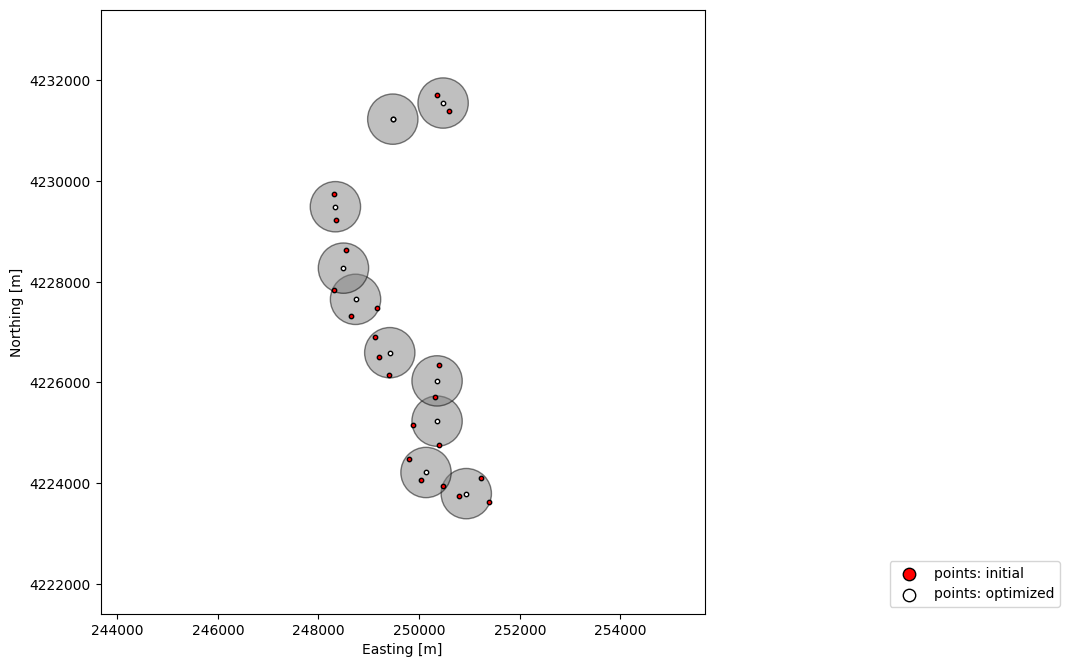

In [77]:
layout.REP_RADIUS = 500
layout.optimize_measurements('initial')
layout.plot_optimization()

Let's see what happend here. First of all we called method: <br>
``` 
layout.optimize_measurements('initial')
```

This method requires string input which indicates what measurement points should be run through the optimization rutine. In our case we have pointed the method to *initial* measurement points. Then method runs a disc covering problem on the set of measurement points (read details about this in [the paper](https://www.wind-energ-sci-discuss.net/wes-2019-13/)). The method derives a minimum number of discs whith radius of 500 m (see *layout.REP_RADIUS*) that cover all the measurement points. Afterwards the disc centers are copied to  *layout.measurements_dictionary* as *optimized* measurement points. You are free to play with the value of the disc radius by changing the attribute *layout.REP_RADIUS*, and then re-runing the optimization with the new configuration. <br>

The second method:<br>
```
layout.plot_optimization()
```
simply plots the results of the optimization, you can see both the position of *initial* and *optimized* measurement points.

Before we start generating GIS layers which will help us navigate positioning of two lidars let us change some attributes of the CPT class, specifically expected averaged range of lidars and mesh extent. 
But before we do that let's check the default values for these attributes:

In [99]:
print(layout.AVERAGE_RANGE)
print(layout.MESH_EXTENT)

3000
6000


The values of both attributes are in meters. 
The mesh extent indicates how big area the generated GIS layers will occupy.<br> By default the layers will occupy area of 10x10km at the barycenter of measurement points.<br>The indicated MESH_EXTENT of 5000 m is basically added and substracted from the mesh center coordinates to generate the GIS layer corners.
<br><br>Since the measurement points at the Italian site are quite wide spreaded we need to increase the mesh extent, while increasing the default average range to 4000 m since the site is close to the coast where we expect an increased level of aerosols.

In [100]:
layout.MESH_EXTENT = 6000 # in meters
layout.AVERAGE_RANGE = 3000 # in meters

Now lets generate the GIS layer for placing of the first lidar. The method that we need to call is:
```
layout.generate_first_lidar_placement_layer(points_id)
```
where point_id is a string indicating which measurement points should be used in this process.
<br> We will set *points_id* to '*optimized*':

In [101]:
layout.generate_first_lidar_placement_layer('optimized')

Generating combined layer for optimized measurement points!
Correct latitudinal zone!
Correct longitudinal zone!
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
Station 1 of 1
First lidar placement layer generated with landcover data!


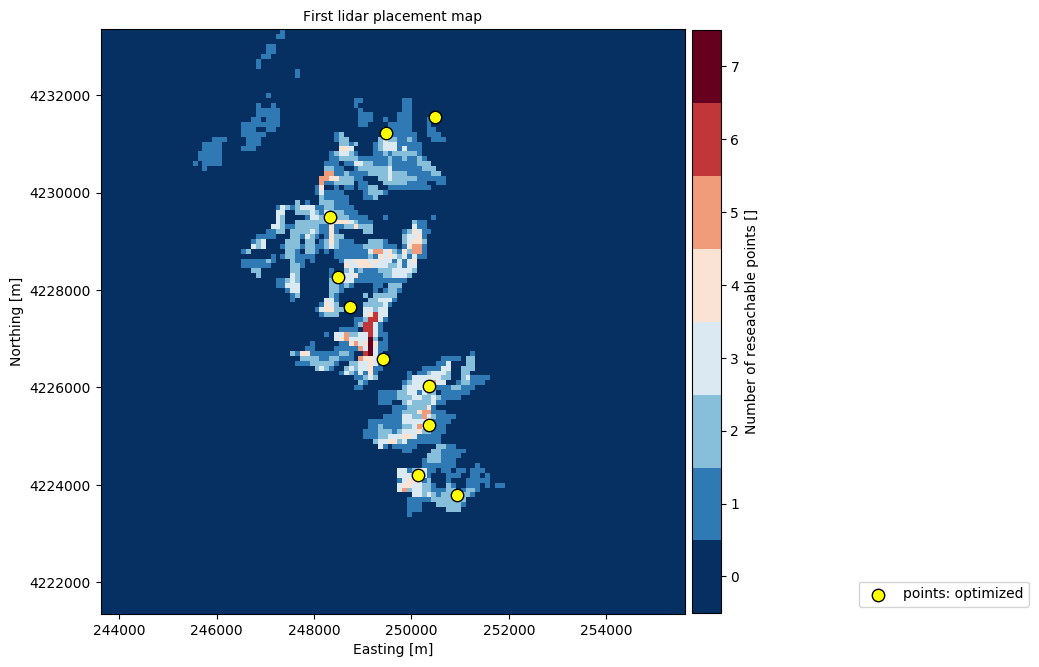

In [102]:
layout.plot_layer('first_lidar_placement', title = 'First lidar placement map')

The plot shows you areas where if you place lidar you will be able to reach a certain number of measurement points considering a number of constriants such as:
* Range
* Unobstracted line-of-sight
* Elevation angle
* Restriction zones 

Currently the CPT library don't provide an interactive way of placing lidar or optimization routine to do this for you. <br>Therefore, for time being you will have to this manually.<br>

You have two options of performing this task. <br>
You can export the above layer to KML by using following built-in method:
```
layout.lidar_position_suggestion(filename, **kwargs)
```
You can use another built-in method to get a list of potential positions:<br>
```
layout.lidar_position_suggestion(layer_id, teshold)
```
We will the first method:<br>

In [103]:
layout.export_kml('first_lidar', layer_ids = ['first_lidar_placement'])
first_lidar_positions = layout.lidar_position_suggestion('first_lidar_placement', 6)

KML exported successful!


In the first method we are providing the KML file name followed with *layer_id* suppiled as a list.<br>
Based on Google Earth survey we have identified position for the first lidar and add it to the lidar dictionary:

Lidar 'ws1' added to the lidar dictionary, which now contains 2 lidar instance(s).
Updating lidar instance 'ws1' considering GIS layer 'first_lidar_placement'.


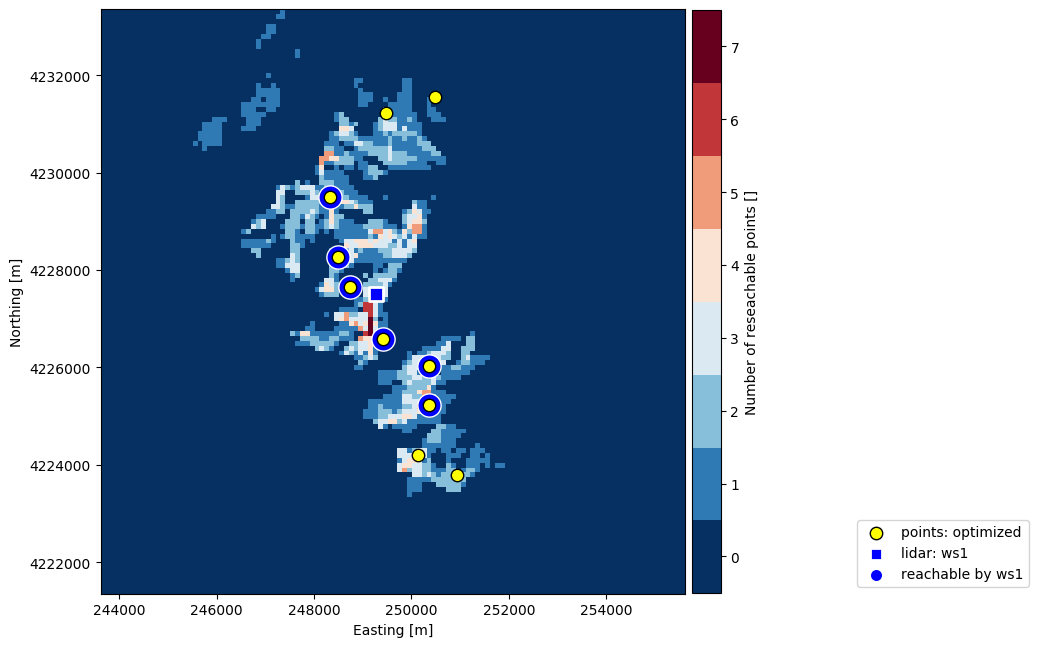

In [124]:
layout.add_lidar_instance('ws1', first_lidar_positions[12], layer_id = 'first_lidar_placement')
layout.plot_layer('first_lidar_placement', lidar_ids = ['ws1'])

What happened in the previous two lines of code? 
<br>First we call method
```
layout.add_lidar_instance(lidar_id, position, kwargs)
```
which adds lidar position to the lidar dictionary.<br>
In our case we provided this method with following parameters:
* lidar_id ='*ws1*'
* position, which was identified by inspecting GIS layer in Google Earth
* layer_id = '*first_lidar_placement*'

The last parameter points the method to extract information about the reachable points from a specific GIS layer, which in the case of the first lidar placement is *'first_lidar_placement'* and updates the lidar dictionary instance 'ws1' accordingly. <br>
You can access the lidar dictionary instance by calling:
```
layout.lidar_dictionary['ws1']
```
, and if you inspect specifically the following key:
```
layout.lidar_dictionary['ws1']['reachable_points']
```
you can see that the returned array contains 13 elements (same lenght as points) where 11 elemenets have values equal to 1 and two elements have value equal to 0. The value eqaul to 1 means that a correponding measurement point is reachable, while the value equal to 0 means that the point is not reachable. <br>Inspect other elements of the lidar dictionary. We will use them at the later stage.

In [111]:
layout.lidar_dictionary['ws1']['reachable_points']

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 0.])

Since we have selected the first lidar position, let's add the second lidar. 
<br>Now we need to add one more contraint, which is the minimum intersecting angle between laser beams.
By calling 
```
layout.MIN_INTERSECTING_ANGLE
```
you can see what is the preset value in degrees.<br>
For time being we will use the default value of 30 degrees and create so called <br>*'additional lidar placement layer'*
<br> To do this we will call method 
```
layout.generate_additional_lidar_placement_layer(lidar_id)
```
where *lidar_id* will be set to *'ws1'*, since that is the id of our first lidar.

Updating lidar instance 'ws1' considering GIS layer 'first_lidar_placement'.


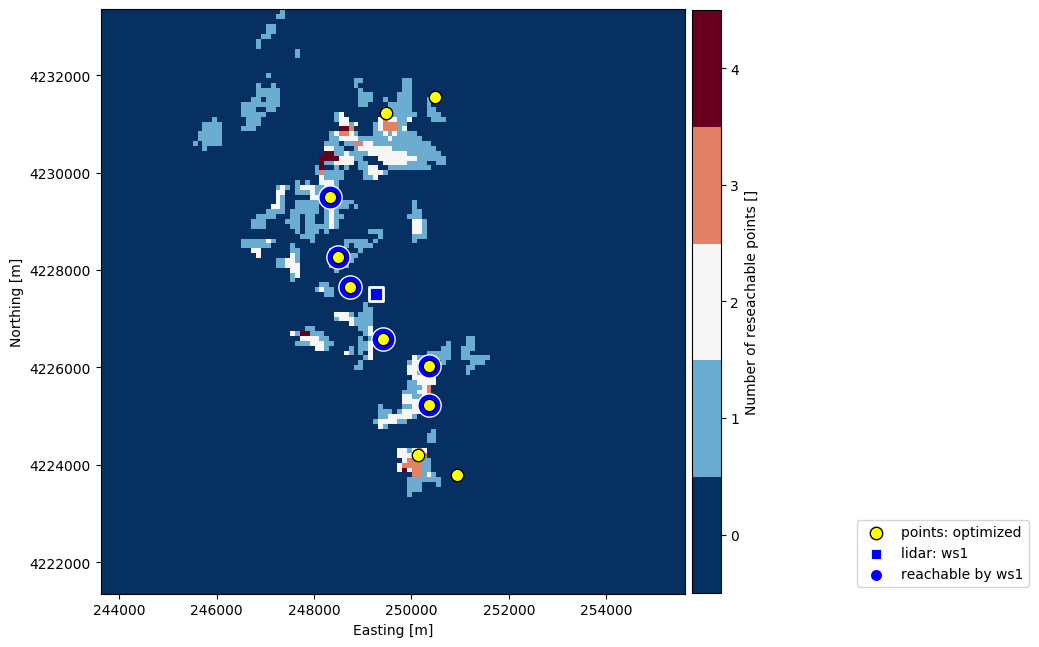

In [125]:
layout.generate_additional_lidar_placement_layer('ws1')
layout.plot_layer('additional_lidar_placement', lidar_ids = ['ws1'])

In the above plot of the new GIS layer you can see that some areas which in the previous plot were indicated as a good areas for lidar installation are removed. The reason for this is that if the second lidar was placed at those areas the intersecting angle between the first and second lidar would be lower than 30 degrees.
<br>
With this new result we can see that where ever you put the second lidar you will not be able to reach more than 9 measurement points. Accordingly we set the treshold for `layout.lidar_position_suggestion()` method to 9 which helps us to find the position of the second lidar:

In [126]:
second_lidar_positions = layout.lidar_position_suggestion('additional_lidar_placement', 4)

In [127]:
second_lidar_positions[1]

array([ 247772, 4226705,    1492])

Lidar 'ws2' added to the lidar dictionary, which now contains 2 lidar instance(s).
Updating lidar instance 'ws2' considering GIS layer 'additional_lidar_placement'.


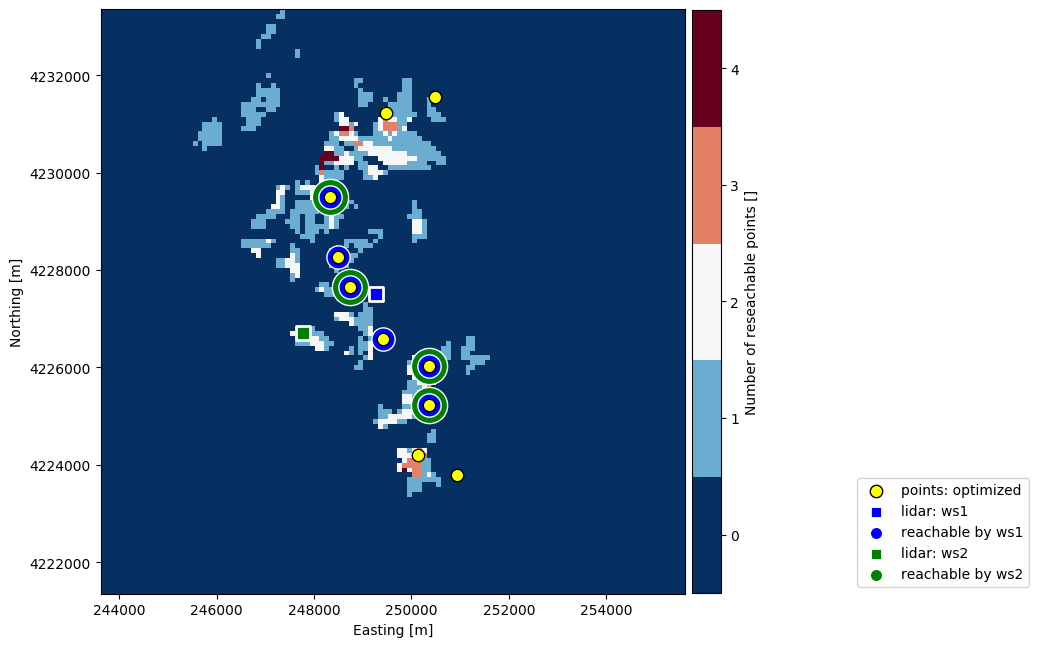

In [130]:
layout.add_lidar_instance('ws2', second_lidar_positions[1],layer_id = 'additional_lidar_placement')  
layout.plot_layer('additional_lidar_placement', lidar_ids = ['ws1', 'ws2'])

Actually, once we place the second lidar, we are only able to reach 7 out of 13 optimized measurement points.<br> 
For the end let's optimize the trajectory through the commong reachable points for the two lidars and export results:

At this point we have positions of our dual-Doppler system and we are ready to optimize trajectory, plot campaign design and export lidars configurations. We will use the following built-in methods for this:<br>
```
layout.optimize_trajectory(lidar_ids, **kwargs)
layout.plot_design(layer_id, lidar_ids, **kwargs)
layout.export_measurement_scenario(layer_id)
```
Additionally we will export KML containing layers, lidar positions and trajectory:<br>
```
layout.export_kml(filename, **kwargs)
```

In [133]:
layout.optimize_trajectory(['ws1', 'ws2'], sync = True, only_common_points = True)

Lidar instances:['ws1', 'ws2'] will be updated with the optimized trajectory
Synchronizing trajectories for lidar instances:['ws1', 'ws2']


In this method we set kwargs *sync* and *only_common_points* to True. The first kwarg will assure synchronized trajectories, while the second kwarg assure that trajectory will consider only measurement points reachable by both lidars. The optimize_trajectory method currently only generates step-stare trajectories. <br>
You can access lidar dictionary and the result of this method (i.e., access key 'motion_config').

In [134]:
layout.lidar_dictionary['ws1']['motion_config']

,Step-stare order,Azimuth [deg],Elevation [deg],Move time [ms]
0,4->1,285.24,4.94,3115.0
1,1->2,334.77,4.48,1491.0
2,2->3,143.67,2.22,3879.0
3,3->4,154.51,2.59,777.0


Trajectory motion time [s]: 9.26


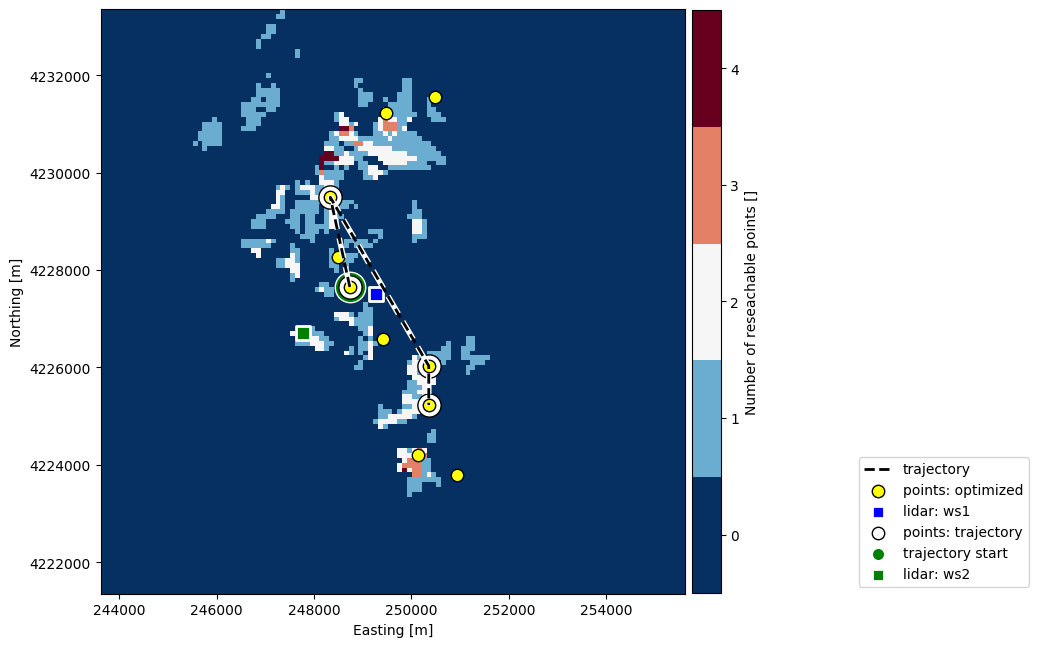

In [135]:
print('Trajectory motion time [s]: ' 
      + str(round(np.sum(layout.lidar_dictionary['ws1']['motion_config'].values[:,-1])/1000,2)))
layout.plot_design('additional_lidar_placement', lidar_ids = ['ws1', 'ws2'])

In [136]:
layout.export_measurement_scenario(['ws1', 'ws2'])
layout.export_kml('campaign_desing', 
                  layer_ids = ['first_lidar_placement','additional_lidar_placement'],
                  lidar_ids = ['ws1', 'ws2'])

Measurement scenario export successful!
KML exported successful!


The last method will export following files:
1. Motion program to drive scanner heads (PMC file)
2. Range gate file to configure laser and FPGA (TXT file)
3. YAML and XML files containing human and machine readable compilation of information from (1) and (2)

Motion programs and range gate files are currently only applicable for [long-range WindScanners](https://www.mdpi.com/2072-4292/8/11/896).
<br>Now you are all equiped to make scanning lidar measurements!

## Appendix: verification of the optimized trajectory
For the purpose of verifying that the optimized trajectory is really the shortest in duration we will generate all possible trajectories by making permutation of trajectory points. In this example this is feasible since the trajectory contains only 4 measurement points, thus there is 4! = 24 possible trajectories. 

In [143]:
all_trajectories = np.asarray(list(permutations(layout.trajectory.values[:,1:].tolist())))
lidar_ids= ['ws1', 'ws2']

The next block of code will iterate through the trajectory array and for each trajectory calculate the total move time considering:

In [144]:
sync_time_list = []
no_it = len(all_trajectories)
for i,trajectory in enumerate(all_trajectories):
    
    sync_time = []
    for lidar in lidar_ids:

        motion_table = layout.generate_trajectory(
                layout.lidar_dictionary[lidar]['position'], 
                trajectory)

        timing = motion_table.loc[:, 'Move time [ms]'].values
        sync_time = sync_time + [timing]
    
    # Synchronize the trajectory time for two lidars
    # by taking the maximum move time between two of them
    # for each trajectory point:
    sync_time = np.sum(np.max(np.asarray(sync_time).T, axis = 1))
    sync_time_list = sync_time_list + [sync_time]
    print("Progress {:2.1%}".format(i / no_it), end="\r")

sync_time_list = np.asarray(sync_time_list)

In [153]:
print('Average time: \t' + str(round(np.mean(sync_time_list)/1000,2)) +' s')
print('Max time: \t' + str(round(np.max(sync_time_list)/1000,2)) +' s')
print('Min time: \t' + str(round(np.min(sync_time_list)/1000,2)) +' s')
print('Std: \t\t' + str(round(np.std(sync_time_list)/1000,2)) +' s')


Average time: 	11.13 s
Max time: 	14.42 s
Min time: 	9.26 s
Std: 		2.34 s
